# Lunar Lander
The objective of this exercise is to land a lunar lander gently on the surface of the moon. The lunar lander environment is provided by [Open AI Gym](https://github.com/openai/gym). The gym environment receives an action and returns a reward value and the new state of the lander. The state of the lander is a 8 dimensional vector with the following components.
* The coordinates of the lander in x & y.
* Its linear velocities in x & y.
* Its angle.
* Its angular velocity.
* Two booleans that represent whether each leg is in contact with the ground or not.

The action is derieved from a set of 4 discrete values:
* 0 (Do nothing)
* 1 (Fire the left orientation engine)
* 2 (Fire the main engine)
* 3 (Fire the right orientation engine)]

The gym environment can receive one action at each timestep.

# References
* [RL using OpenAI Gym](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)
* [Deep Q-Learning](https://github.com/adventuresinML/adventures-in-ml-code/blob/master/r_learning_tensorflow.py)
* [Lunar Lander by vsaveris](https://github.com/vsaveris/lunar-lander-DQN)

In [3]:
%%capture
# Let's start by installing a few required packages. The installation requirements depend on the execution environments.

# Lunar Lander gym environment.
! pip install gym gym[box2d]

# Visualization of the animation.
! pip install ipywidgets

In [2]:
%%capture
# simple neural network implementation of qlearning
import gym
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import layers, optimizers
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from collections import deque
from statistics import mean

## Initialization

/Users/broxoli/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


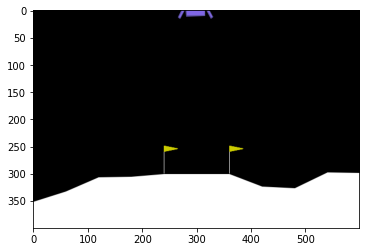

In [4]:
seed = 111

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For Kaggle
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Lunar Lander environment initialization
env = gym.make("LunarLander-v2")
obs = env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)

## Lander Model

In [5]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

def create_model():
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(N_STATES)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu", name='prunable'),
        layers.Dense(N_ACTIONS, activation='linear')
    ])
    
    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

model = create_model()
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 prunable (Dense)            (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


2022-07-04 10:22:58.252862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-04 10:22:58.253959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training
The training process involves two phases which occur alternatively for each episode. An episode terminates with a successful landing, a crash or the expiration of allowed timesteps (1000 steps). The 'Trainer' collects experience in the first phase by interacting with the gym environment. The model is training in the second phase using the accumulated experiences.

The loss function used in this exercise is the Q Learning Loss function which takes the next state rewards into account for the current state rewards. It's akin to looking one timestep in the future.

In [6]:
GAMMA = .99
DECAY_FACTOR = .99995
BATCH_SIZE = 64
MAX_EPISODES = 800
# MAX_EPISODES = 2
ACCEPTABLE_AVERAGE_SCORE_THRESHOLD = 190
MAX_ACCEPTABLE_AVG_SCORE_COUNTER = 100

def Trainer(m, callbacks=[]):
    memory = []
    last_100_scores = deque(maxlen=100)
    epsilon = 1.0
    acceptable_avg_score_counter = 0

    def choosePlay(state):
        nonlocal epsilon
        random_action = lambda: np.random.randint(N_ACTIONS)
    
        def predicted_action():
            q_values = m(tf.expand_dims(state, 0))
            action = tf.squeeze(tf.argmax(q_values, axis=-1))
            return action.numpy()
        
        action =  random_action() if np.random.random() <= epsilon else predicted_action()
        epsilon *= DECAY_FACTOR

        return action
    
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state

    def play(state):
        action = choosePlay(state)
        obs, reward, done, _ = env.step(action)
        new_state = obs_to_state(obs)

        return action, reward, new_state, done
    
    def train_step(state):
        # Play to gain experience
        action, reward, new_state, done = play(state)
        new_state = np.zeros_like(state) if done else new_state

        # Store experience in the memory bank
        memory.append((state, action, reward, new_state))

        # Train the network with a batch of the gained experience
        batch = np.asarray(random.sample(memory, min(len(memory), BATCH_SIZE)), dtype=object)
        q_s_a = m.predict(np.stack(batch[:, 0], axis = 0))  #Q(s,a)   
        q_s_a_next = m.predict(np.stack(batch[:, 3], axis = 0))  #Q(s',a)

        for item_id in range(batch.shape[0]):
            if np.array_equal(batch[item_id, 3], np.zeros(N_STATES)):
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2]
            else:
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2] + GAMMA*np.amax(q_s_a_next[item_id, :])

        m.fit(np.stack(batch[:, 0], axis = 0), q_s_a, batch_size=BATCH_SIZE, verbose=0, callbacks=callbacks)
        
        return new_state, reward, done
    
    def record_episode(episode_id, step_id, score, reward, results):
        nonlocal acceptable_avg_score_counter

        # Update the last 100 scores queue with the latest score
        last_100_scores.append(score)

        # Collect episode results
        mean_last_100_scores = mean(last_100_scores)
        results.append((step_id, reward, score, mean_last_100_scores))
        
        # Increment the counter if the episode scores past the acceptance threshold
        # Reset the counter if the episode falls below the acceptance threshold
        if mean_last_100_scores > ACCEPTABLE_AVERAGE_SCORE_THRESHOLD:
            acceptable_avg_score_counter += 1
        else:
            acceptable_avg_score_counter = 0

        print(
            'Episode:', episode_id,
            'Steps:', step_id,
            'Score:', score,
            '100_rolling_average:', mean_last_100_scores,
            'Acceptable Average Score Count:', acceptable_avg_score_counter,
        )

    def train(episodes=MAX_EPISODES, steps=1000):
        results = []

        for episode_id in range(episodes):
            obs = env.reset()
            state = obs_to_state(obs)
            score = 0

            for step_id in range(steps):
                state, reward, done = train_step(state)
                score += reward
                
                if done:
                    record_episode(episode_id, step_id, score, reward, results)
                    break
            
            # Terminate training if the average score meet the acceptance threshold
            # for MAX_ACCEPTABLE_AVG_SCORE_COUNTER episodes in sequence.
            if acceptable_avg_score_counter >= MAX_ACCEPTABLE_AVG_SCORE_COUNTER:
                break

        return results
    
    return train

trainer = Trainer(model)
results = trainer()

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)

model.save_weights('lunar_lander.h5')

2022-07-04 10:23:08.930343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-04 10:23:09.021194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 10:23:09.247063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 10:23:12.556338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 10:23:15.972768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Episode: 0 Steps: 130 Score: -219.57738702153972 100_rolling_average: -219.57738702153972 Acceptable Average Score Count: 0
Episode: 1 Steps: 74 Score: -104.6143240674677 100_rolling_average: -162.0958555445037 Acceptable Average Score Count: 0


Label(value='Training Results')

,Steps,Reward,Score,R100_Score,Done,Crashed
0,87,-100.0,-340.623242,-340.623242,False,True
1,85,-100.0,-114.124701,-227.373972,False,True
2,91,-100.0,-345.138391,-266.628778,False,True
3,88,-100.0,-459.853148,-314.934871,False,True
4,96,-100.0,-124.661282,-276.880153,False,True
...,...,...,...,...,...,...
531,452,100.0,163.824104,237.808079,True,False
532,347,100.0,192.322490,236.901748,True,False
533,323,100.0,250.572877,236.924639,True,False
534,223,-100.0,20.541748,236.597877,False,True


Successes: 249 Crashes: 159 Timeouts: 128


Label(value='Top Scores')

,Steps,Reward,Score,R100_Score,Done,Crashed
477,437,100.0,302.887524,231.071392,True,False
499,459,100.0,300.616596,234.318107,True,False
527,222,100.0,295.355968,239.186626,True,False
519,337,100.0,293.431639,236.809725,True,False
454,337,100.0,291.543025,213.212000,True,False


Label(value='Bottom Scores')

,Steps,Reward,Score,R100_Score,Done,Crashed
2,91,-100.0,-345.138391,-266.628778,False,True
14,104,-100.0,-423.339091,-221.742244,False,True
3,88,-100.0,-459.853148,-314.934871,False,True
16,131,-100.0,-477.471067,-236.440451,False,True
181,533,-100.0,-754.354674,-96.976513,False,True


Label(value='Training Benchmarks')

,Start,End,Count,Successes,Crashes,Timeouts
0,0,200,123,0,123,0
1,200,300,30,23,7,0
2,300,500,127,116,11,0
3,500,700,78,70,8,0
4,700,1000,178,40,10,128


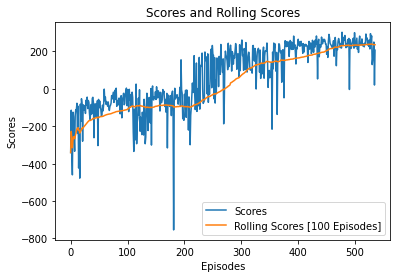

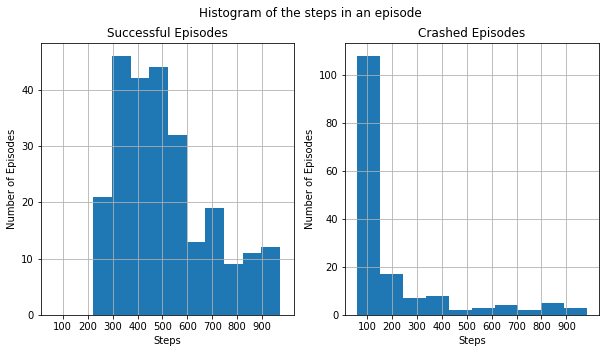

In [7]:
from ipywidgets import Label

def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Reward', 'Score', 'R100_Score']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['Done'] = df['Reward'] == 100
    df['Crashed'] = df['Reward'] == -100

    # Plot rolling scores
    plt.plot(df['Score'], label='Scores')
    plt.plot(df['R100_Score'], label='Rolling Scores [100 Episodes]')
    plt.legend()
    plt.title('Scores and Rolling Scores')
    plt.xlabel('Episodes')
    plt.ylabel('Scores')

    display(Label('Training Results'), df)

def summarize_results(file):
    df = load_results(file)
    show_results(df)

    # Display Summary
    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    # Top and bottom scores
    sorted_scores = df.sort_values('Score', ascending=False)
    display(Label('Top Scores'), sorted_scores.head())
    display(Label('Bottom Scores'), sorted_scores.tail())
    
    steps_benchmarks = [0, 200, 300, 500, 700, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)
    
    # Training Benchmarks
    display(Label('Training Benchmarks'), benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1000, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

# summarize_results('v23/lunar_lander.results.pkl')
summarize_results('lunar_lander.results.pkl')

## Trial Run

In [9]:

def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render(mode='rgb_array')
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))
       
    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,2e9))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

def trial_run(m):
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state
    
    def predicted_action(state):
        q_values = m(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    obs = env.reset()
    score = 0
    frames = []

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = predicted_action(state)
        obs, reward, done, _ = env.step(action)
        score += reward
        
        # Save visuals
        save_visuals(env, frames)

        if done:
            print('Finished with total score:', score, 'in steps: ', step_id)
            break
    
    print('Total Score:', score, 'Done:', done)
    return frames

# model.load_weights('v23/lunar_lander.h5')
container, frames = {}, trial_run(model)
save_frames_as_gif(container, 0, frames)

Finished with total score: 249.92245012662266 in steps:  312
Total Score: 249.92245012662266 Done: True


## Animation Visualization

In [10]:
import ipywidgets as ipyw

def create_expanded_button(description, button_style):
    return ipyw.Button(description=description, button_style=button_style, layout=ipyw.Layout(height='auto', width='auto'))

def image_widget(file):
    with open(file, "rb") as file:
        image = file.read()
        # return Image(value=image, width=w, height=h)
        return ipyw.Image(value=image)

def image_label_widget(title, file):
    image = image_widget(file)
    label = ipyw.Label(value=title)
    layout = ipyw.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid')
    box = ipyw.Box(children=[image, label], layout=layout)
    return box

def display_gifs_grid(images, cols=5):
    rows = (len(images)+cols-1) // cols
    grid = ipyw.GridspecLayout(rows, cols)

    for index, image in images.items():
        gcol = index%cols
        grow = index//cols

        grid[grow, gcol] = image_label_widget(str(index), image)
    
    return grid

display_gifs_grid(container, cols=1)


GridspecLayout(children=(Box(children=(Image(value=b'GIF89aX\x02\x90\x01\x87\x00\x00\xff\xff\xff\xfc\xfc\xfc\x…